# CIFAR10 Image Classification using Keras 简洁版

In [5]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
%matplotlib inline

nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [8]:
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda
from keras.models import Model
import tensorflow as tf

def make_parallel(model, gpu_count):

    def get_slice(data, idx, parts):
        shape = tf.shape(data)
        size = tf.concat([shape[:1] // parts, shape[1:]], axis=0)
        stride = tf.concat([shape[:1] // parts, shape[1:] * 0], axis=0)
        start = stride * idx
        return tf.slice(data, start, size)

    outputs_all = []
    for i in range(len(model.outputs)):
        outputs_all.append([])

    # Place a copy of the model on each GPU, each getting a slice of the batch
    for i in range(gpu_count):
        with tf.device('/gpu:%d' % i):
            with tf.name_scope('tower_%d' % i) as scope:

                inputs = []
                # Slice each input into a piece for processing on this GPU
                for x in model.inputs:
                    input_shape = tuple(x.get_shape().as_list())[1:]
                    slice_n = Lambda(get_slice, output_shape=input_shape, arguments={'idx': i, 'parts': gpu_count})(x)
                    inputs.append(slice_n)

                outputs = model(inputs)

                if not isinstance(outputs, list):
                    outputs = [outputs]

                # Save all the outputs for merging back together later
                for l in range(len(outputs)):
                    outputs_all[l].append(outputs[l])

    # merge outputs on CPU
    # 也可以设为GPU，如果CPU负载已经很大的话
    with tf.device('/cpu:0'):
        merged = []
        for outputs in outputs_all:
            merged.append(Concatenate(axis=0)(outputs))
        return Model(model.inputs, merged)

In [30]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Flatten()(y)
y = Dropout(0.5)(y)
y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

model1 = Model(inputs=x, outputs=y, name='model1')

model1 = make_parallel(model1, 2)

model1.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
lambda_15 (Lambda)               (None, 32, 32, 3)     0           input_14[0][0]                   
____________________________________________________________________________________________________
lambda_16 (Lambda)               (None, 32, 32, 3)     0           input_14[0][0]                   
____________________________________________________________________________________________________
model1 (Model)                   (None, 10)            4705866     lambda_15[0][0]                  
                                                                   lambda_16[0][0]         

In [ ]:
nb_epoch = 100
batch_size = 256
start = time.time()
h = model1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(X_test, y_test), shuffle=True)
model1.save('CIFAR10_model_dual_GPU_1.h5')
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

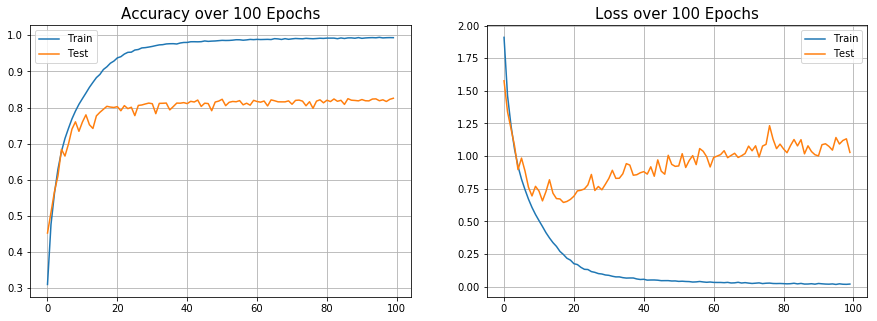

In [11]:
def plot_acc_loss(h, nb_epoch):
    acc, loss, val_acc, val_loss = h.history['acc'], h.history['loss'], h.history['val_acc'], h.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(nb_epoch), acc, label='Train')
    plt.plot(range(nb_epoch), val_acc, label='Test')
    plt.title('Accuracy over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(nb_epoch), loss, label='Train')
    plt.plot(range(nb_epoch), val_loss, label='Test')
    plt.title('Loss over ' + str(nb_epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(h, nb_epoch)

In [ ]:
model1 = load_model('CIFAR10_model_dual_GPU_1.h5')

In [ ]:
aug_gen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

aug_gen.fit(X_train)
gen = aug_gen.flow(X_train, y_train, batch_size=batch_size)
h = model1.fit_generator(generator=gen, steps_per_epoch=50000//batch_size, epochs=nb_epoch, validation_data=(X_test, y_test))
model1.save('CIFAR10_model_dual_GPU_2.h5')

Epoch 1/100
195/195 [==============================] - 13s - loss: 2.0162 - acc: 0.2647 - val_loss: 1.9591 - val_acc: 0.2759
Epoch 2/100
195/195 [==============================] - 11s - loss: 1.5790 - acc: 0.4262 - val_loss: 1.3304 - val_acc: 0.5205
Epoch 3/100
195/195 [==============================] - 11s - loss: 1.3553 - acc: 0.5174 - val_loss: 1.1263 - val_acc: 0.5973
Epoch 4/100
195/195 [==============================] - 12s - loss: 1.1626 - acc: 0.5872 - val_loss: 0.9652 - val_acc: 0.6650
Epoch 5/100
195/195 [==============================] - 11s - loss: 1.0181 - acc: 0.6409 - val_loss: 0.8502 - val_acc: 0.7001
Epoch 6/100
195/195 [==============================] - 11s - loss: 0.9072 - acc: 0.6820 - val_loss: 0.7946 - val_acc: 0.7263
Epoch 7/100
195/195 [==============================] - 11s - loss: 0.8276 - acc: 0.7117 - val_loss: 0.8220 - val_acc: 0.7176
Epoch 8/100
195/195 [==============================] - 11s - loss: 0.7486 - acc: 0.7402 - val_loss: 0.6960 - val_acc: 0.7617
